Device: cpu
Shape: (30000, 10)
Columns: ['age', 'sex', 'education', 'education-num', 'marital-status', 'workclass', 'occupation', 'hours-per-week', 'income', 'label']
Categorical sizes: [('sex', 2), ('education', 14), ('marital-status', 6), ('workclass', 5), ('occupation', 12)]
Embedding sizes (col, (n_cat, emb_dim)): [(2, 1), (14, 7), (6, 3), (5, 3), (12, 6)]
cats shape: (30000, 5)
Total rows n = 30000
cats_t: torch.Size([30000, 5]) conts_t: torch.Size([30000, 2]) y: torch.Size([30000])
Train shapes: torch.Size([25000, 5]) torch.Size([25000, 2]) torch.Size([25000])
Test shapes : torch.Size([5000, 5]) torch.Size([5000, 2]) torch.Size([5000])
TabularModel(
  (embeds): ModuleList(
    (0): Embedding(2, 1)
    (1): Embedding(14, 7)
    (2): Embedding(6, 3)
    (3): Embedding(5, 3)
    (4): Embedding(12, 6)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin1): Linear(in_features=22, out_features

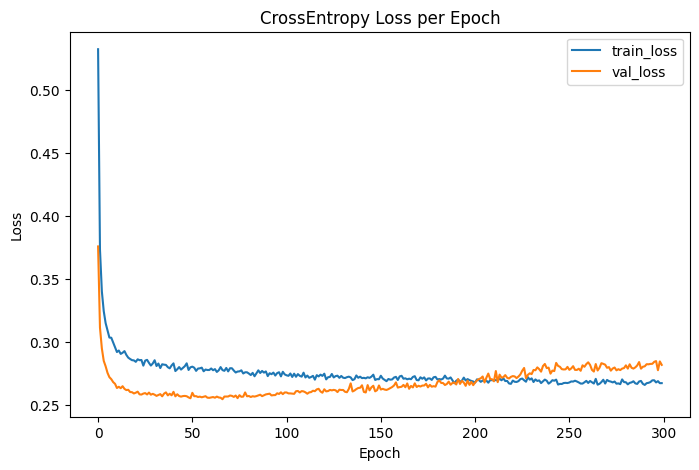

Test Loss: 0.2815
Test Accuracy: 0.8756 (4378/5000)
Category mapping examples (first few):
sex [('Female', 0), ('Male', 1)]
education [('10th', 0), ('11th', 1), ('12th', 2), ('5th-6th', 3), ('7th-8th', 4), ('9th', 5)]
marital-status [('Divorced', 0), ('Married', 1), ('Married-spouse-absent', 2), ('Never-married', 3), ('Separated', 4), ('Widowed', 5)]
workclass [('Federal-gov', 0), ('Local-gov', 1), ('Private', 2), ('Self-emp', 3), ('State-gov', 4)]
occupation [('Adm-clerical', 0), ('Craft-repair', 1), ('Exec-managerial', 2), ('Farming-fishing', 3), ('Handlers-cleaners', 4), ('Machine-op-inspct', 5)]
Example prediction: {'<=50K_prob': 0.19195851683616638, '>50K_prob': 0.8080414533615112, 'pred_class': 1}
Done. Save this notebook as notebooks/census_income_workshop.ipynb, add requirements.txt and README.md and push to GitHub.


In [1]:
# census_income_workshop.ipynb
# Full solution for Census Income Workshop (PyTorch)
# Thanglish comments included

# 0) Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
import random
from torch.utils.data import TensorDataset, DataLoader

# 0.1) Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# 1) Load dataset
# Put 'income.csv' in the same folder as this notebook or adjust path
DATA_PATH = "income.csv"   # change if needed (notebooks/.. etc)
df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()

# 2) Separate column names
# According to the exercise: 5 categorical columns, 2 continuous, 1 label named 'label'
# The dataset columns should include: age, sex, education, education_num, marital-status,
# workclass, occupation, hours-per-week, income, label
# Use 'label' as the target (0 or 1)
# We'll pick categorical columns: sex, education (or education_num), marital-status, workclass, occupation
# continuous: age, hours-per-week

# Confirm columns
print("Columns:", list(df.columns))

# Assign lists (if your dataset column names differ slightly, change here)
# Use 'education' and not 'education_num' for categorical here (either is acceptable per instructions)
cat_cols = ['sex', 'education', 'marital-status', 'workclass', 'occupation']
cont_cols = ['age', 'hours-per-week']
y_col = 'label'   # use 'label' (IMPORTANT)

# Quick check that these columns exist
for c in cat_cols + cont_cols + [y_col]:
    if c not in df.columns:
        raise ValueError(f"Column '{c}' not found in dataset. Adjust column names accordingly.")

# 3) Convert categorical columns to 'category' dtype
for c in cat_cols:
    df[c] = df[c].astype('category')

# 4) Optional: shuffle (dataset already shuffled per problem statement)
# df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

# 5) cat_szs and emb_szs
cat_szs = [int(df[c].nunique()) for c in cat_cols]
# Embedding size rule: min(50, (cat_size+1)//2) (common heuristic)
emb_szs = [(sz, min(50, (sz+1)//2)) for sz in cat_szs]
print("Categorical sizes:", list(zip(cat_cols, cat_szs)))
print("Embedding sizes (col, (n_cat, emb_dim)):", emb_szs)

# 6) Create cats numpy array: stack of cat.codes
cats = np.stack([df[c].cat.codes.values for c in cat_cols], axis=1)
print("cats shape:", cats.shape)
# 7) Convert cats to tensor (int64)
cats_t = torch.tensor(cats, dtype=torch.int64)

# 8) Create continuous array and convert to tensor (float32)
conts = np.stack([df[c].values for c in cont_cols], axis=1).astype(np.float32)
scaler = StandardScaler()
conts = scaler.fit_transform(conts)
conts_t = torch.tensor(conts, dtype=torch.float32)

# 9) Create label tensor (flattened)
y = torch.tensor(df[y_col].values, dtype=torch.long).view(-1)

# Quick sanity
n = len(df)
print("Total rows n =", n)
print("cats_t:", cats_t.shape, "conts_t:", conts_t.shape, "y:", y.shape)

# 10) Train/test split (use 25,000 train and 5,000 test)
# The dataset has 30,000 rows per problem statement
b = n           # total batch size (should be 30000)
t = 5000        # test size
if b < 25000 + t:
    raise ValueError(f"Dataset too small for requested train/test sizes: b={b}, need >= 30000")

# We'll take first (b - t) as train and last t as test (dataset assumed shuffled)
train_idx = list(range(0, b - t))
test_idx  = list(range(b - t, b))

cat_train = cats_t[train_idx]
cont_train = conts_t[train_idx]
y_train = y[train_idx]

cat_test = cats_t[test_idx]
cont_test = conts_t[test_idx]
y_test = y[test_idx]

print("Train shapes:", cat_train.shape, cont_train.shape, y_train.shape)
print("Test shapes :", cat_test.shape,  cont_test.shape,  y_test.shape)

# 11) Create DataLoaders (optional: smaller batch for faster iter)
BATCH_SIZE = 256
train_ds = TensorDataset(cat_train, cont_train, y_train)
test_ds  = TensorDataset(cat_test, cont_test, y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

# 12) Define TabularModel
class TabularModel(nn.Module):
    def __init__(self, emb_szs, n_cont, hidden_layers=50, drop_p=0.4):
        super().__init__()
        # embedding layers
        self.embeds = nn.ModuleList([nn.Embedding(n_cat, emb_dim) for n_cat, emb_dim in emb_szs])
        self.emb_drop = nn.Dropout(drop_p)
        self.n_emb = sum([emb_dim for _, emb_dim in emb_szs])
        # batchnorm for continuous inputs
        self.bn_cont = nn.BatchNorm1d(n_cont)
        # first layer (emb + cont) -> hidden
        self.lin1 = nn.Linear(self.n_emb + n_cont, hidden_layers)
        self.bn1 = nn.BatchNorm1d(hidden_layers)
        self.drop1 = nn.Dropout(drop_p)
        # output layer: 2 classes
        self.out = nn.Linear(hidden_layers, 2)

    def forward(self, x_cat, x_cont):
        # x_cat: (batch, n_cat_cols)
        if x_cat is not None and len(self.embeds)>0:
            embs = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeds)]
            x = torch.cat(embs, 1)
            x = self.emb_drop(x)
        else:
            x = torch.zeros((x_cont.size(0), self.n_emb), device=x_cont.device)

        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = F.relu(self.bn1(self.lin1(x)))
        x = self.drop1(x)
        x = self.out(x)
        return x

# create model
model = TabularModel(emb_szs, n_cont=len(cont_cols), hidden_layers=50, drop_p=0.4).to(device)
print(model)

# 13) Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 14) Training loop (300 epochs requested)
EPOCHS = 300  # change to 50 for faster debug then set to 300
history = {"train_loss": [], "val_loss": []}

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    for cat_b, cont_b, y_b in train_loader:
        cat_b = cat_b.to(device)
        cont_b = cont_b.to(device)
        y_b = y_b.to(device)

        optimizer.zero_grad()
        outputs = model(cat_b, cont_b)
        loss = criterion(outputs, y_b)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * y_b.size(0)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    history["train_loss"].append(epoch_train_loss)

    # Validation (every epoch)
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for cat_b, cont_b, y_b in test_loader:
            cat_b = cat_b.to(device)
            cont_b = cont_b.to(device)
            y_b = y_b.to(device)
            outputs = model(cat_b, cont_b)
            loss = criterion(outputs, y_b)
            val_loss += loss.item() * y_b.size(0)
    epoch_val_loss = val_loss / len(test_loader.dataset)
    history["val_loss"].append(epoch_val_loss)

    # Print progress occasionally
    if (epoch+1) % 25 == 0 or epoch < 5:
        print(f"Epoch {epoch+1}/{EPOCHS} — train_loss: {epoch_train_loss:.4f}  val_loss: {epoch_val_loss:.4f}")

# 15) Plot CrossEntropy Loss vs epochs
plt.figure(figsize=(8,5))
plt.plot(history['train_loss'], label='train_loss')
plt.plot(history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('CrossEntropy Loss per Epoch')
plt.show()

# 16) Evaluate on test set and compute accuracy
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for cat_b, cont_b, y_b in test_loader:
        cat_b = cat_b.to(device)
        cont_b = cont_b.to(device)
        y_b = y_b.to(device)
        outputs = model(cat_b, cont_b)
        loss = criterion(outputs, y_b)
        test_loss += loss.item() * y_b.size(0)
        _, preds = torch.max(outputs, dim=1)
        correct += (preds == y_b).sum().item()
        total += y_b.size(0)

test_loss = test_loss / total
accuracy = correct / total
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f} ({correct}/{total})")

# 17) BONUS: function to predict for a new input (interactive or dict)
# IMPORTANT: mapping for categorical values must match the training category ordering.
# We'll create dicts from df[c].cat.categories to map string->code.

cat_maps = {c: {cat: code for code, cat in enumerate(df[c].cat.categories)} for c in cat_cols}
print("Category mapping examples (first few):")
for c in cat_cols:
    print(c, list(cat_maps[c].items())[:6])

def predict_from_dict(sample_dict):
    """
    sample_dict: dictionary with keys = cat_cols + cont_cols
    categorical values must be the same strings as in dataset
    Example:
    sample = {
      'sex':'Male', 'education':'Bachelors', 'marital-status':'Married',
      'workclass':'Private', 'occupation':'Exec-managerial',
      'age': 37, 'hours-per-week': 40
    }
    returns probabilities and class
    """
    # build categorical list (codes)
    cat_list = []
    for c in cat_cols:
        val = sample_dict[c]
        if val not in cat_maps[c]:
            raise ValueError(f"Value '{val}' not found for column '{c}'. Allowed: {list(cat_maps[c].keys())}")
        cat_list.append(cat_maps[c][val])
    # continuous values: scale with scaler
    cont_list = []
    for i, c in enumerate(cont_cols):
        cont_list.append((sample_dict[c] - scaler.mean_[i]) / scaler.scale_[i])

    x_cat = torch.tensor([cat_list], dtype=torch.int64).to(device)
    x_cont = torch.tensor([cont_list], dtype=torch.float32).to(device)

    model.eval()
    with torch.no_grad():
        out = model(x_cat, x_cont)
        probs = torch.softmax(out, dim=1).cpu().numpy()[0]
        pred_class = int(np.argmax(probs))
    return {"<=50K_prob": float(probs[0]), ">50K_prob": float(probs[1]), "pred_class": pred_class}

# Example usage:
example = {
    'sex':'Male',
    'education':'Bachelors',
    'marital-status':'Married',
    'workclass':'Private',
    'occupation':'Exec-managerial',
    'age':37,
    'hours-per-week':40
}
print("Example prediction:", predict_from_dict(example))

# 18) Save model & artifacts (optional)
torch.save({
    'model_state_dict': model.state_dict(),
    'scaler': scaler,
    'emb_szs': emb_szs,
    'cat_cols': cat_cols,
    'cont_cols': cont_cols,
    'cat_maps': cat_maps
}, "census_tabular_model.pth")

print("Done. Save this notebook as notebooks/census_income_workshop.ipynb, add requirements.txt and README.md and push to GitHub.")
